In [66]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.io import votable
from astropy.table import Table
from astropy.io import fits
from astropy.coordinates import SkyCoord
import astropy.units as u

# Investigating Positions of Known Globuluar Clusters

In [67]:
# Load PMGC dataset from Vasilev et al. 2019 (PMGC_vasiliev2019res.fit)
# This is used for cross-matching with the Gaia dataset
PMGC_path = 'data/PMGC_vasiliev2019.fit'
with fits.open(PMGC_path) as PMGC_hdul:
    PMGC_data = Table(PMGC_hdul[1].data).to_pandas()

# Convert RA/Dec to Galactic coordinates (l, b)
sky_coords = SkyCoord(ra=PMGC_data['RAJ2000'].values * u.degree, 
                      dec=PMGC_data['DEJ2000'].values * u.degree, 
                      frame='icrs')
galactic_coords = sky_coords.galactic
PMGC_data['l'] = galactic_coords.l.deg
PMGC_data['b'] = galactic_coords.b.deg


# Load the data from Milky Way Satellites Census - (Drlica-Wagner et al. 2020)
MWC_path = 'data/MWCens_DW2020.fit'
with fits.open(MWC_path) as MWC_hdul:
    MWC_data = Table(MWC_hdul[1].data).to_pandas()

# Convert RA/Dec to Galactic coordinates (l, b)
sky_coords = SkyCoord(ra=MWC_data['RAJ2000'].values * u.degree, 
                      dec=MWC_data['DEJ2000'].values * u.degree, 
                      frame='icrs')
galactic_coords = sky_coords.galactic
MWC_data['l'] = galactic_coords.l.deg
MWC_data['b'] = galactic_coords.b.deg

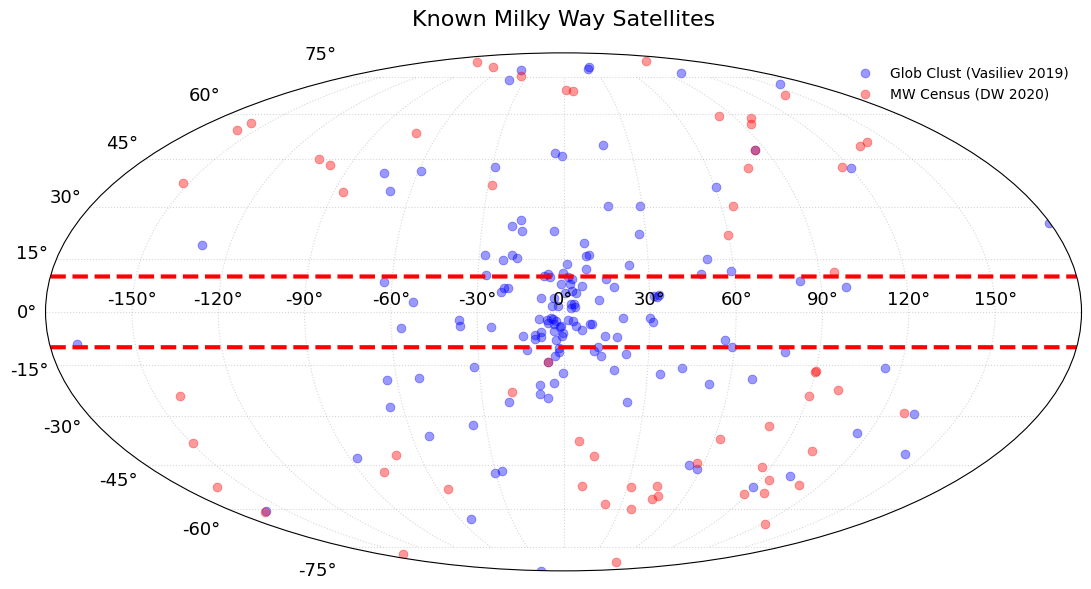

In [68]:
# --- Convert Galactic l to Mollweide format ---
def transform_to_mollweide(l_deg, b_deg):
    l_shifted = (l_deg + 180) % 360 - 180  # shift to [-180, 180]
    l_shifted = -l_shifted                 # flip for Mollweide
    return np.radians(l_shifted), np.radians(b_deg)

# --- Transform PMGC ---
l_pmgc_rad, b_pmgc_rad = transform_to_mollweide(PMGC_data['l'], PMGC_data['b'])

# --- Transform MWCens ---
l_mwc_rad, b_mwc_rad = transform_to_mollweide(MWC_data['l'], MWC_data['b'])

# --- Plot ---
fig = plt.figure(figsize=(12, 6))
ax = fig.add_subplot(111, projection='mollweide')

# PMGC (blue, edge)
ax.scatter(l_pmgc_rad, b_pmgc_rad,
           s=40, facecolors='blue', edgecolors='blue',
           linewidths=0.6, alpha=0.4, label='Glob Clust (Vasiliev 2019)')

# MWCens (orange, edge)
ax.scatter(l_mwc_rad, b_mwc_rad,
           s=40, facecolors='red', edgecolors='red',
           linewidths=0.6, alpha=0.4, label='MW Census (DW 2020)')

# --- Axis formatting ---
ax.grid(True, linestyle='dotted', alpha=0.5)
ax.set_title("Known Milky Way Satellites", fontsize=16, pad=20)

# Longitude ticks
tick_labels = ["-150°", "-120°", "-90°", "-60°", "-30°", "0°", "30°", "60°", "90°", "120°", "150°"]
tick_positions = np.radians([-150, -120, -90, -60, -30, 0, 30, 60, 90, 120, 150])
ax.set_xticks(tick_positions)
ax.set_xticklabels(tick_labels, fontsize=13)
ax.tick_params(axis='y', labelsize=13)

# Add red dotted lines at b = ±10°
b_limit_rad = np.radians(10)
ax.plot(np.linspace(-np.pi, np.pi, 100), [b_limit_rad]*100, color='red', linestyle='--', linewidth=3)
ax.plot(np.linspace(-np.pi, np.pi, 100), [-b_limit_rad]*100, color='red', linestyle='--', linewidth=3)


# Add legend
ax.legend(loc='upper right', fontsize=10, frameon=False)

plt.tight_layout()
plt.show()

# Investigating Proper Motion of Known Globuluar Clusters
- This notebook aims to determine the typical proper motion of known globuluar clusters using Vasiliev, 2019 `Proper motions and dynamics of the Milky Way globular cluster system from Gaia DR2`.

- This is in an aim to further filter the gaia data during query to identify Halo substructures

In [69]:
# Loading the data
PMGC_path = 'data/PMGC_vasiliev2019.fit'
with fits.open(PMGC_path) as PMGC_hdul:
    PMGC_data = Table(PMGC_hdul[1].data).to_pandas()
    display(PMGC_data.describe())

,RAJ2000,DEJ2000,Dist,HRV,e_HRV,pmRA,pmDE,e_pmRA,e_pmDE,corr,Rscale,Nstar,recno
count,150.000000,150.000000,149.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000,150.000000
mean,239.400421,-22.539160,16.197315,-1.674535,1.006200,-1.802960,-3.588580,0.067213,0.066013,-0.000333,3.947333,1211.093333,75.500000
std,67.988785,26.742607,21.388643,140.881683,1.831912,3.194479,3.522490,0.025633,0.022090,0.062978,3.478056,3153.796477,43.445368
min,6.024000,-82.213997,2.200000,-406.220001,0.080000,-12.490000,-19.000999,0.039000,0.039000,-0.471000,0.400000,9.000000,1.000000
25%,230.229252,-36.475250,7.200000,-93.882500,0.280000,-3.800500,-5.328000,0.057000,0.057000,-0.001000,1.825000,94.000000,38.250000
50%,261.578003,-26.310500,9.400000,-4.860000,0.515000,-2.025500,-3.023000,0.063000,0.063000,0.005500,2.800000,241.500000,75.500000
75%,272.970505,-7.691250,15.600000,81.034998,1.055000,-0.065250,-1.428500,0.068000,0.067000,0.012750,5.200000,917.000000,112.750000
max,347.110992,79.581001,145.000000,494.339996,14.140000,9.833000,7.115000,0.288000,0.184000,0.167000,25.200001,23917.000000,150.000000


In [70]:
# Calculate the absolute values
PMGC_data['abs_pmRA'] = PMGC_data['pmRA'].abs()
PMGC_data['abs_pmDE'] = PMGC_data['pmDE'].abs()
PMGC_data['pm_total'] = np.sqrt(PMGC_data['pmRA']**2 + PMGC_data['pmDE']**2)

In [71]:
potential_pm_limit_1 = 4
potential_pm_limit_2 = 12

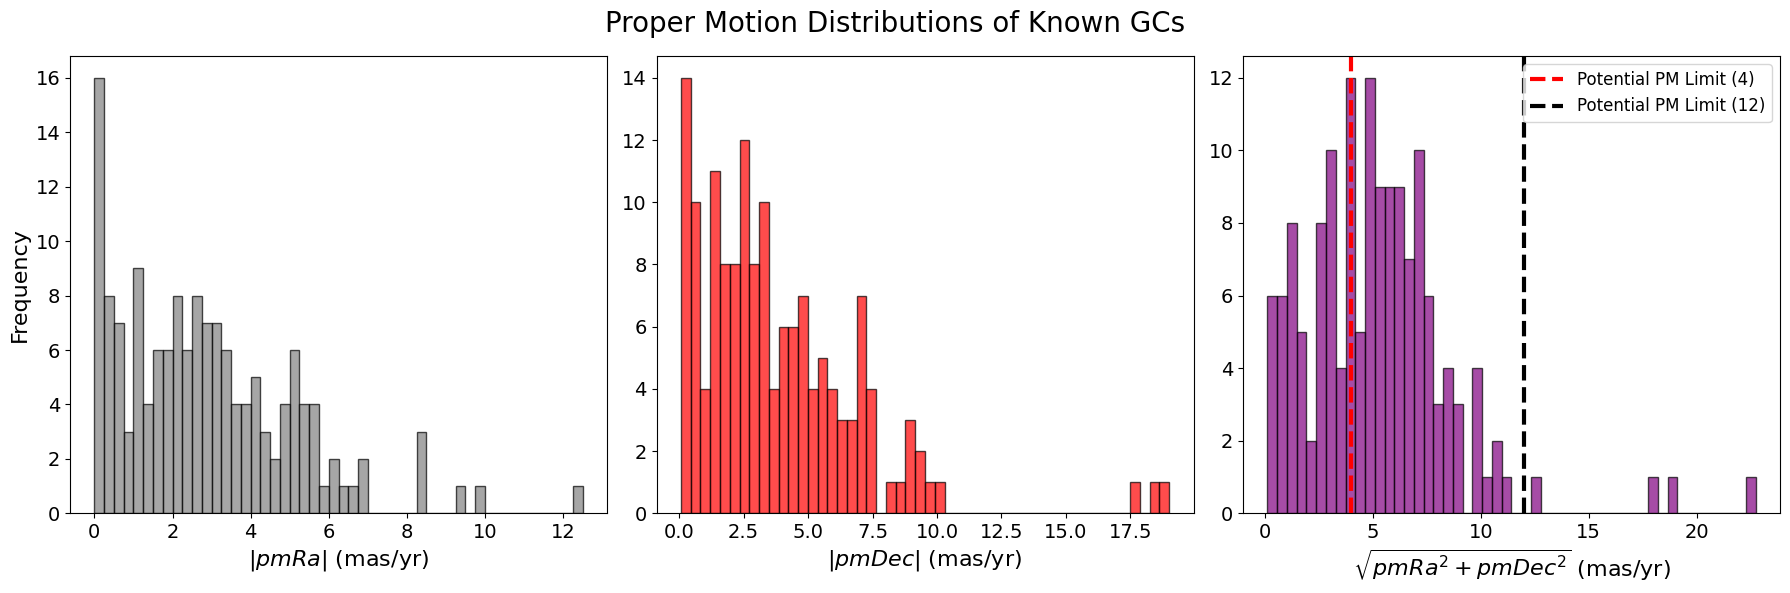

In [72]:
# Plot histograms
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Title
fig.suptitle('Proper Motion Distributions of Known GCs', fontsize=20)

axes[0].hist(PMGC_data['abs_pmRA'], bins=50, color='grey', alpha=0.7, edgecolor='black')
axes[0].set_xlabel('$|pm Ra|$ (mas/yr)', fontsize=16)
axes[0].set_ylabel('Frequency', fontsize=16)
axes[0].tick_params(axis='both', which='major', labelsize=14)

axes[1].hist(PMGC_data['abs_pmDE'], bins=50, color='red', alpha=0.7, edgecolor='black')
axes[1].set_xlabel('$|pm Dec|$ (mas/yr)', fontsize=16)
axes[1].tick_params(axis='both', which='major', labelsize=14)

axes[2].hist(PMGC_data['pm_total'], bins=50, color='purple', alpha=0.7, edgecolor='black')
axes[2].set_xlabel('$\sqrt{pm Ra^2 + pm Dec^2}$ (mas/yr)', fontsize=16)
axes[2].tick_params(axis='both', which='major', labelsize=14)
axes[2].axvline(potential_pm_limit_1, color='red', linestyle='--', linewidth=3, label = 'Potential PM Limit (4)')
axes[2].axvline(potential_pm_limit_2, color='black', linestyle='--', linewidth=3, label = 'Potential PM Limit (12)')
axes[2].legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()

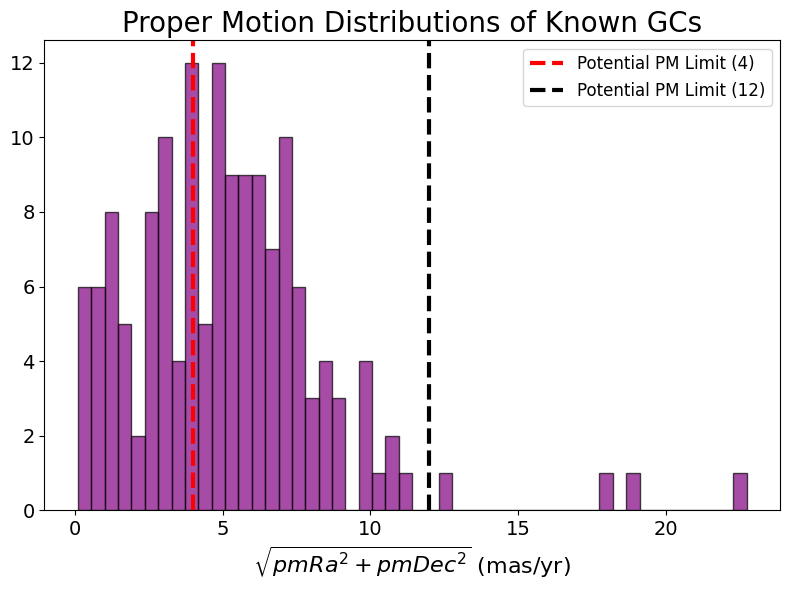

In [73]:
# Plot histograms
fig, axes = plt.subplots(1, 1, figsize=(8, 6))

# Title
plt.title('Proper Motion Distributions of Known GCs', fontsize=20)

plt.hist(PMGC_data['pm_total'], bins=50, color='purple', alpha=0.7, edgecolor='black')
plt.xlabel('$\sqrt{pm Ra^2 + pm Dec^2}$ (mas/yr)', fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=14)
plt.axvline(potential_pm_limit_1, color='red', linestyle='--', linewidth=3, label = 'Potential PM Limit (4)')
plt.axvline(potential_pm_limit_2, color='black', linestyle='--', linewidth=3, label = 'Potential PM Limit (12)')
plt.legend(loc='upper right', fontsize=12)

plt.tight_layout()
plt.show()

In [74]:
# Summary table
summary_stats_pm = {
    'Statistic': ['Mean', 'Median', 'Max', 'Standard Deviation'],
    '|pmRA|': [
        PMGC_data['abs_pmRA'].mean(),
        PMGC_data['abs_pmRA'].median(),
        PMGC_data['abs_pmRA'].max(),
        PMGC_data['abs_pmRA'].std()
    ],
    r'|pmDE|': [
        PMGC_data['abs_pmDE'].mean(),
        PMGC_data['abs_pmDE'].median(),
        PMGC_data['abs_pmDE'].max(),
        PMGC_data['abs_pmDE'].std()
    ],
    r'\sqrt{pmRA^2 + pmDE^2}': [
        PMGC_data['pm_total'].mean(),
        PMGC_data['pm_total'].median(),
        PMGC_data['pm_total'].max(),
        PMGC_data['pm_total'].std()
    ]
}

summary_stats_pm_df = pd.DataFrame(summary_stats_pm)
display(summary_stats_pm_df)

,Statistic,|pmRA|,|pmDE|,\sqrt{pmRA^2 + pmDE^2}
0,Mean,2.876000,3.830193,5.196834
1,Median,2.572500,3.085500,5.028615
2,Max,12.490000,19.000999,22.738472
3,Standard Deviation,2.269425,3.256291,3.414836
